<a href="https://colab.research.google.com/github/parthgoe1/Siamese-Neural-Network/blob/master/s1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import decimal
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [0]:
torch.__version__

'0.4.1'

In [0]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

    100% |████████████████████████████████| 5.7MB 4.8MB/s 
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1 which is incompatible.
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


In [0]:
training_dir = "/content/drive/My Drive/dataset1/train/"
testing_dir = "/content/drive/My Drive/dataset1/test/"
train_batch_size = 64
train_number_epochs = 100

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  
    
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [0]:
folder_dataset = dset.ImageFolder(root=training_dir)

In [0]:
#1
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [0]:
#1
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()])                                                                      
                                       ,should_invert=False)


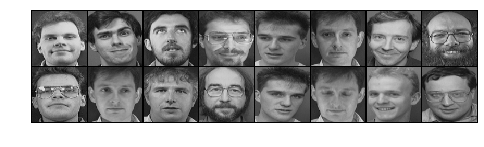

[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [0]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        #num_workers=8,
                        batch_size=8)

dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())


In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):

        super(SiameseNetwork, self).__init__()
        
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=10, stride=1, padding=0),
            nn.LeakyReLU(inplace=True),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=1, padding=0),
            nn.LeakyReLU(inplace=True),
            #nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(256)
            
        )
        
        self.fc1 = nn.Sequential(
          nn.Linear(256 * 6 * 6, 4096),
          nn.Sigmoid()
        )
        
        self.fc2 = nn.Sequential(
          nn.Linear(4096,1)
        )
        
     
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
      
    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        # compute l1 distance
        diff = torch.abs(output1 - output2)
        output= self.fc2(diff)
        return output


      
      
      

In [0]:
#weights initializiation
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.01)
        m.bias.data.normal_(0.5, 0.01)

    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        
        
        m.bias.data.fill_(0)    

    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.2)
        m.bias.data.normal_(0.5, 0.01) 


In [0]:
# Training the model

# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        #num_workers=8,
                        batch_size=train_batch_size)


In [0]:
net = SiameseNetwork().cuda().double()
#criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

Epoch number 0
 Current loss 0.451423530564



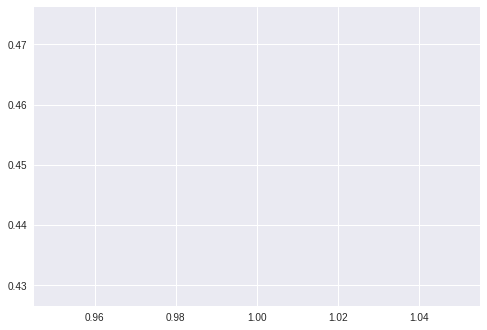

Epoch number 1
 Current loss 0.500335815324

Epoch number 2
 Current loss 0.49963171365

Epoch number 3
 Current loss 0.443467732959

Epoch number 4
 Current loss 0.489486303455

Epoch number 5
 Current loss 0.448174871316

Epoch number 6
 Current loss 0.363542811535

Epoch number 7
 Current loss 0.401159147166

Epoch number 8
 Current loss 0.375645161912

Epoch number 9
 Current loss 0.228307139226

Epoch number 10
 Current loss 0.3269460277



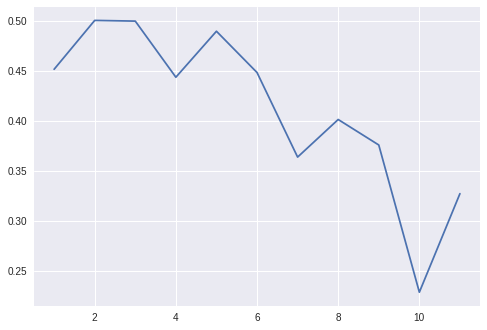

Epoch number 11
 Current loss 0.227939786954

Epoch number 12
 Current loss 0.293243085276

Epoch number 13
 Current loss 0.362923593208

Epoch number 14
 Current loss 0.295453019341

Epoch number 15
 Current loss 0.244787256511

Epoch number 16
 Current loss 0.226969378908

Epoch number 17
 Current loss 0.182315448096

Epoch number 18
 Current loss 0.166700788804

Epoch number 19
 Current loss 0.135499339119

Epoch number 20
 Current loss 0.148903103455



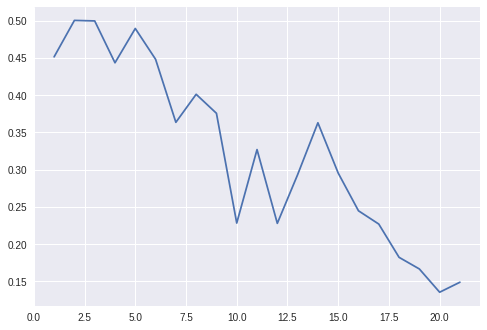

Epoch number 21
 Current loss 0.100748653369

Epoch number 22
 Current loss 0.285201389416

Epoch number 23
 Current loss 0.0870414476594

Epoch number 24
 Current loss 0.180214998353

Epoch number 25
 Current loss 0.128858424295

Epoch number 26
 Current loss 0.108680053728

Epoch number 27
 Current loss 0.187681608743

Epoch number 28
 Current loss 0.126999402868

Epoch number 29
 Current loss 0.187108943531

Epoch number 30
 Current loss 0.134486634218



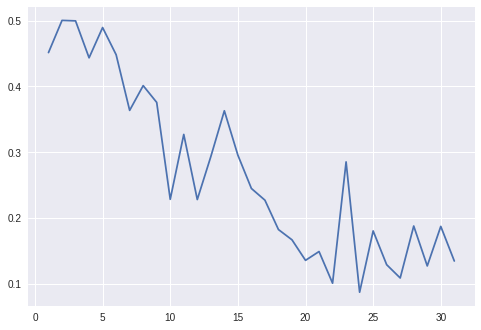

Epoch number 31
 Current loss 0.0952634469569

Epoch number 32
 Current loss 0.0437169963818

Epoch number 33
 Current loss 0.067806621314

Epoch number 34
 Current loss 0.0965744173419

Epoch number 35
 Current loss 0.0484490950846

Epoch number 36
 Current loss 0.0928760354646

Epoch number 37
 Current loss 0.0603258529986

Epoch number 38
 Current loss 0.0595180016148

Epoch number 39
 Current loss 0.129522690799

Epoch number 40
 Current loss 0.0741831472352



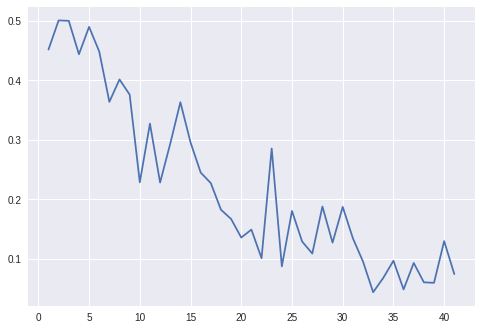

Epoch number 41
 Current loss 0.149906345587

Epoch number 42
 Current loss 0.0867537603536

Epoch number 43
 Current loss 0.0805550269593

Epoch number 44
 Current loss 0.0523311221418

Epoch number 45
 Current loss 0.0573703758682

Epoch number 46
 Current loss 0.0673922500491

Epoch number 47
 Current loss 0.0587522697407

Epoch number 48
 Current loss 0.061543485114

Epoch number 49
 Current loss 0.017921924077

Epoch number 50
 Current loss 0.0532092945372



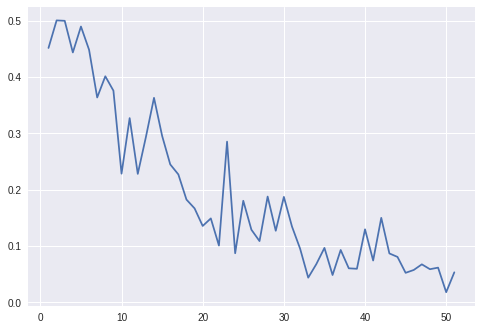

Epoch number 51
 Current loss 0.053275458934

Epoch number 52
 Current loss 0.150862485775

Epoch number 53
 Current loss 0.0657423756212

Epoch number 54
 Current loss 0.0570820815436

Epoch number 55
 Current loss 0.0802461735086

Epoch number 56
 Current loss 0.0697492184721

Epoch number 57
 Current loss 0.0802084493095

Epoch number 58
 Current loss 0.048145170387

Epoch number 59
 Current loss 0.0236526067059

Epoch number 60
 Current loss 0.0479066911178



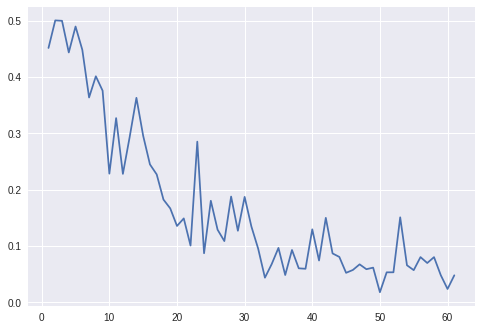

Epoch number 61
 Current loss 0.0292334656272

Epoch number 62
 Current loss 0.0175900423502

Epoch number 63
 Current loss 0.0474269021209

Epoch number 64
 Current loss 0.0300587991619

Epoch number 65
 Current loss 0.0439132727958

Epoch number 66
 Current loss 0.0676100358573

Epoch number 67
 Current loss 0.106164443406

Epoch number 68
 Current loss 0.0369138354287

Epoch number 69
 Current loss 0.0922072014513

Epoch number 70
 Current loss 0.0728314222533



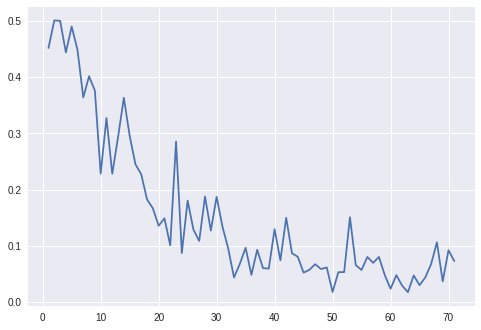

Epoch number 71
 Current loss 0.0270719389984

Epoch number 72
 Current loss 0.0599073199635

Epoch number 73
 Current loss 0.0949603566204

Epoch number 74
 Current loss 0.0635881882833

Epoch number 75
 Current loss 0.0349968707697

Epoch number 76
 Current loss 0.0509802439157

Epoch number 77
 Current loss 0.0372516346558

Epoch number 78
 Current loss 0.0150443188145

Epoch number 79
 Current loss 0.0169443909219

Epoch number 80
 Current loss 0.041399681492



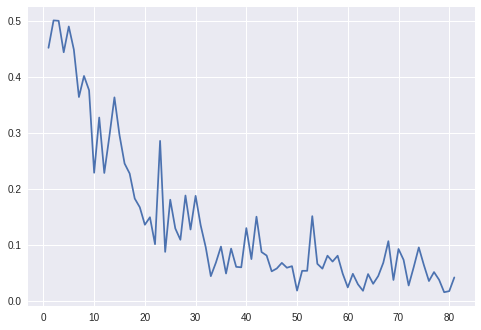

Epoch number 81
 Current loss 0.0762444331073

Epoch number 82
 Current loss 0.0229540728053

Epoch number 83
 Current loss 0.0179383468214

Epoch number 84
 Current loss 0.00617742454057

Epoch number 85
 Current loss 0.0524756172215

Epoch number 86
 Current loss 0.0344567776927

Epoch number 87
 Current loss 0.0346357020558

Epoch number 88
 Current loss 0.0105180952364

Epoch number 89
 Current loss 0.0436044126086

Epoch number 90
 Current loss 0.0129317703028



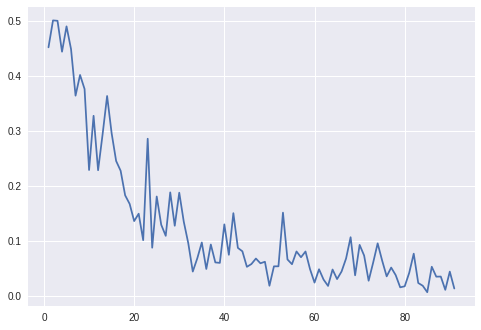

Epoch number 91
 Current loss 0.021654435935

Epoch number 92
 Current loss 0.0551962452622

Epoch number 93
 Current loss 0.0461007695375

Epoch number 94
 Current loss 0.0145609385488

Epoch number 95
 Current loss 0.0332773724633

Epoch number 96
 Current loss 0.026255913433

Epoch number 97
 Current loss 0.0206162869613

Epoch number 98
 Current loss 0.0463565688594

Epoch number 99
 Current loss 0.016321894749



In [0]:
counter=[]
loss_history=[]
iteration_number=0
for epoch in range(0,100):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0.cuda()).double(), Variable(img1.cuda()).double() , Variable(label.cuda()).double()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        #output1,output2 = net(img0,img1)
        output = net(img0,img1)

        # Calculate Loss: Contrastive loss
        #loss_contrastive = criterion(output1,output2,label)
        loss = F.binary_cross_entropy_with_logits(output, label)
        
        # Getting gradients w.r.t. parameters
        loss.backward(retain_graph=True)
        #loss_contrastive.backward(retain_graph=True)
        
        # Updating parameters
        optimizer.step()
        
    print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
       
    iteration_number +=1
    counter.append(iteration_number)
    loss_history.append(loss.item())
    
    if epoch%10==0:
      show_plot(counter,loss_history)    


In [0]:
# Testing the model
folder_dataset_test = dset.ImageFolder(root=testing_dir)

In [0]:
#1
siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)


In [0]:
# Saving the model
torch.save(net.cuda().state_dict(), "/content/drive/My Drive/model_siamese1.pt")
print("Model Saved Successfully")

Model Saved Successfully


In [0]:
# Load the saved model
net = SiameseNetwork().cuda().double()
net.load_state_dict(torch.load("/content/drive/My Drive/model_siamese1.pt"))

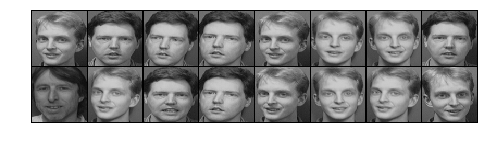

[[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [0]:
vis_dataloader_test = DataLoader(siamese_dataset_test,
                        shuffle=False,
                        #num_workers=8,
                        batch_size=8)

dataiter = iter(vis_dataloader_test)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())


In [0]:
folder_dataset = dset.ImageFolder(root=testing_dir)

In [0]:
#1
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()])                                                                      
                                       ,should_invert=False)


In [0]:
test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)

In [0]:
pred=0
correct=0
total=0
accuracy=0
for i, data in enumerate(test_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0.cuda()).double(), Variable(img1.cuda()).double() , Variable(label.cuda()).double()
        
        output = net(img0,img1)
        
        if output.item() > 5.5:
          pred=1
        else:
          pred=0

        if label.item() == pred:
          correct+=1
        total+=1

accuracy=(correct*100)/total
print(accuracy)


86
